In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math

import statsmodels.api as sm

random_state = 123_456
np.random.seed(random_state)

sns.set()
plt.rc('figure',figsize=(16,12))
plt.rc('font',size=13)

In [2]:
df = pd.read_csv('fuel-prices/all_years_combined.csv', index_col='date', dtype={'price': np.int32}, parse_dates=True)
df.set_index(pd.date_range(min(df.index), periods=df.size, freq='D'), inplace=True, verify_integrity=True)

In [3]:
df['ln_price'] = np.log(df['price'])
df['D_ln_price'] = df['ln_price'].diff()
# df

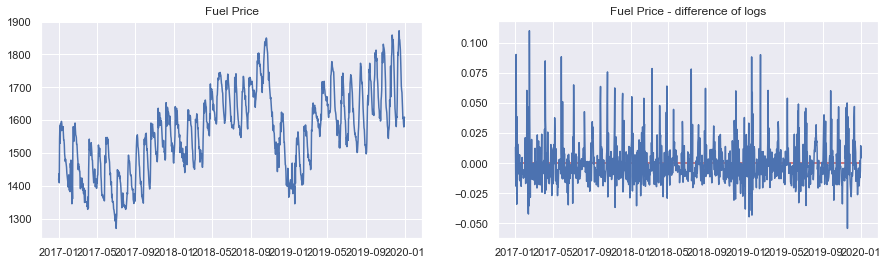

In [4]:
# Graph data
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
    
fig, axes = plt.subplots(1, 2, figsize=(15,4))

# Levels
axes[0].plot(df.index._mpl_repr(), df['price'], '-')
axes[0].set(title='Fuel Price')

# Log difference
axes[1].plot(df.index._mpl_repr(), df['D_ln_price'], '-')
axes[1].hlines(0, df.index[0], df.index[-1], 'r')
axes[1].set(title='Fuel Price - difference of logs');

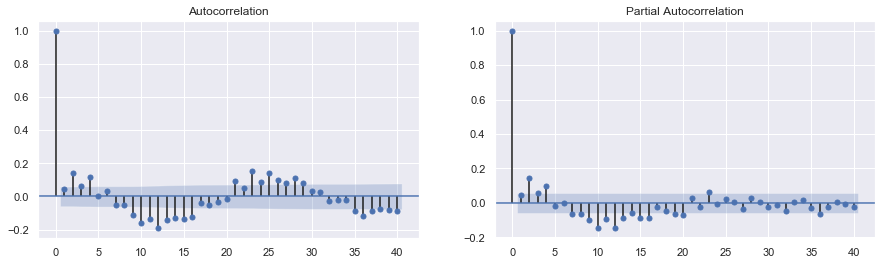

In [5]:
# Graph data
fig, axes = plt.subplots(1, 2, figsize=(15,4))

fig = sm.graphics.tsa.plot_acf(df.iloc[1:]['D_ln_price'], lags=40, ax=axes[0])
fig = sm.graphics.tsa.plot_pacf(df.iloc[1:]['D_ln_price'], lags=40, ax=axes[1])

In [6]:
# Fit the model
mod = sm.tsa.statespace.SARIMAX(df.ln_price, trend='c', order=(1,1,(0,1,0,1)))
res = mod.fit(disp=False)
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 SARIMAX Results                                 
=================================================================================
Dep. Variable:                  ln_price   No. Observations:                 1095
Model:             SARIMAX(1, 1, [2, 4])   Log Likelihood                2849.716
Date:                   Thu, 05 Mar 2020   AIC                          -5689.432
Time:                           15:17:30   BIC                          -5664.444
Sample:                       01-01-2017   HQIC                         -5679.976
                            - 12-31-2019                                         
Covariance Type:                     opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0001      0.001      0.135      0.892      -0.002       0.002
ar.L1          0.0268      0.021      1.251      0.211      -0.015       0.069
ma.L2          0.1160      0.024      4.843      0.000       0.069       0.163
ma.L4          0.1104      0.027      4.089      0.000       0.058       0.163
sigma2         0.0003   9.44e-06     33.863      0.000       0.000       0.000
===================================================================================
Ljung-Box (Q):                      207.38   Jarque-Bera (JB):              1650.66
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.84   Skew:                             1.56
Prob(H) (two-sided):                  0.09   Kurtosis:                         8.15
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [7]:
# res.forecast(steps=7)

In [8]:
# Dynamic predictions
# predict_dy = res.get_prediction(dynamic='2019-12-30').predicted_mean
# predict_dy

In [9]:
# one-step-ahead in-sample predictions for the entire sample
y_hat = np.rint(np.exp(res.get_prediction().predicted_mean))
y_hat.iloc[0] = y_hat.iloc[1]
y_hat

2017-01-01    1417.0
2017-01-02    1417.0
2017-01-03    1437.0
2017-01-04    1411.0
2017-01-05    1542.0
               ...  
2019-12-27    1601.0
2019-12-28    1604.0
2019-12-29    1586.0
2019-12-30    1575.0
2019-12-31    1603.0
Freq: D, Length: 1095, dtype: float64

In [10]:
df

price  ln_price  D_ln_price
2017-01-01   1417  7.256297         NaN
2017-01-02   1436  7.269617    0.013320
2017-01-03   1409  7.250636   -0.018981
2017-01-04   1542  7.340836    0.090200
2017-01-05   1582  7.366445    0.025610
...           ...       ...         ...
2019-12-27   1608  7.382746    0.001867
2019-12-28   1589  7.370860   -0.011886
2019-12-29   1579  7.364547   -0.006313
2019-12-30   1602  7.379008    0.014461
2019-12-31   1609  7.383368    0.004360

[1095 rows x 3 columns]

In [11]:
# np.log([1417])

In [12]:
# np.rint(np.exp([7.25629724]))

In [13]:
def get_relative_accuracy(y_test, y_hat, tolerance_percentage):
    it = np.nditer(y_test, flags=['f_index'])
    non_error_count = 0
    
    while not it.finished:
        upper_limit = it[0] * (1 + tolerance_percentage / 100)
        lower_limit = it[0] - (upper_limit - it[0])
        non_error_count += 1 if y_hat[it.index] < upper_limit and y_hat[it.index] > lower_limit else 0
        it.iternext()
        
    return non_error_count / y_test.size

In [17]:
error_tolerance_percentage = 2.5
get_relative_accuracy(df.price.values, y_hat.values, error_tolerance_percentage)

0.8904109589041096

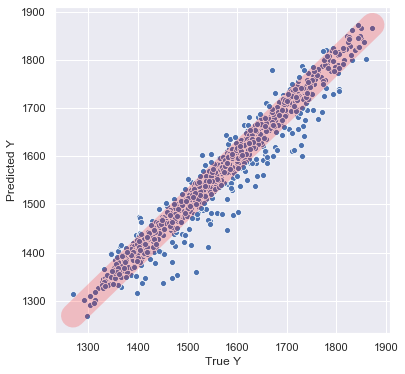

In [15]:
line_x_y = [math.floor(min(df.price.values.min(),y_hat.values.min())), 
            math.ceil(max(df.price.values.max(),y_hat.values.max()))]
_ = plt.figure(figsize = (6, 6))
_ = plt.plot(line_x_y, line_x_y, linewidth=24, alpha=0.2, color='red')
_ = sns.scatterplot(df.price.values.reshape(1,-1)[0], y_hat.values)
_ = plt.ylabel('Predicted Y')
_ = plt.xlabel('True Y')
plt.show()

In [16]:
# df.plot()
# y_hat.plot()
# plt.show()